<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/TRNG_Depenendencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

Remarks on testing dependencies of random bits, with a case study on a TRNG model.

# Utilities

Install dependencies.

In [1]:
!pip install --upgrade statsmodels --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

from statsmodels.graphics.tsaplots import acf
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use('seaborn-white')
plt.rcParams.update({'axes.spines.top':False,'axes.spines.right':False})

# Mixing/Short-Memory Stationarity

Stationarity (time invariance of distribution) and short-memory ()
are needed for ergodicity


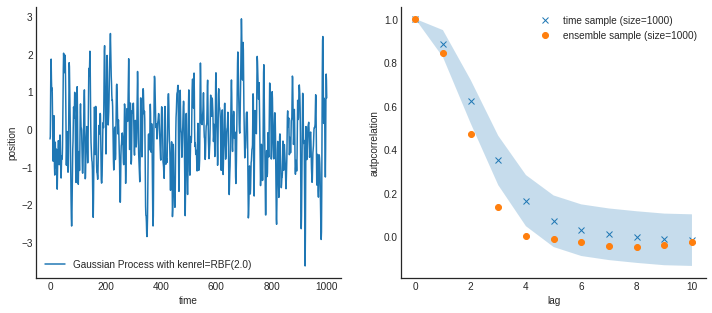

In [3]:
np.random.seed(42)

fig,axs = plt.subplots(1,2,figsize=(12,5))

# define Gaussian Process

gpr = GaussianProcessRegressor(kernel=RBF(2.0))

N_LAGS = 10
lags = np.arange(N_LAGS+1)

# estimate ACF from a time sample

ts = np.arange(1000).reshape(-1,1)
ys = gpr.sample_y(ts)

ax = axs[0]
ax.plot(ts,ys,label='Gaussian Process with kenrel=RBF(2.0)')
ax.set_xlabel('time')
ax.set_ylabel('position')
ax.legend()

time_corrs,confs = acf(ys,nlags=N_LAGS,fft=True,bartlett_confint=True,alpha=0.05)
conf_l,conf_u = confs.T

ax = axs[1]
ax.fill_between(lags,conf_l,conf_u,alpha=0.25)
ax.plot(lags,time_corrs,'x',label='time sample (size=1000)')


# estimate ACF from an ensemble

gpr = GaussianProcessRegressor(kernel=RBF(2.0))
ts = np.arange(0,N_LAGS+1).reshape(-1,1)
ys = gpr.sample_y(ts,n_samples=100)
ensemble_corrs = np.corrcoef(ys)[0]

ax = axs[1]
ax.plot(lags,ensemble_corrs,'o',label='ensemble sample (size=1000)')
ax.set_ylabel('autpcorrelation')
ax.set_xlabel('lag')
ax.legend()
plt.show()

# Testing Stationarity

Consider the standard model of a oscillator-based TRNG, where the output is the first binary digit of Brownian motion.

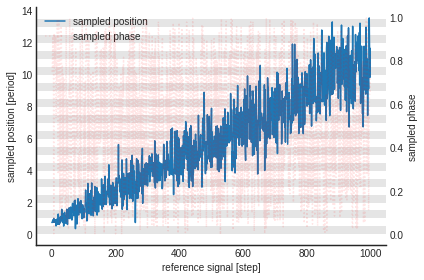

In [4]:
np.random.seed(42)

# simulate oscillator-based TRNG 

mu = 0.01
sigma = 0.5
init = 0.75

ts = np.arange(0,1000)*mu
jitter = np.random.normal(scale=sigma*np.sqrt(ts),size=(len(ts)))
sampled_position = init+ts+jitter
sampled_phase = sampled_position%1
sampled_bit = sampled_phase<1/2

# plot position

fig,ax = plt.subplots(figsize=(6,4))
for i in range(0,14):
  ax.axhspan(0.5*(2*i), 0.5*(2*i+1), color='gray', alpha=0.2, lw=0)
line1 = ax.plot(ts/0.01,sampled_position,label='sampled position')
ax.set_ylabel('sampled position [period]')
ax.set_xlabel('reference signal [step]')

# plot phase

ax2 = ax.twinx()
line2 = ax2.plot(ts/0.01, sampled_phase,label='sampled phase',linestyle='dotted',color='red',alpha=0.1)
ax2.tick_params(axis='y')
ax2.set_ylabel('sampled phase')

lines = line1+line2
labels = [l.get_label() for l in lines]
ax.legend(lines,labels )#,bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.show()
fig.savefig('brownian_motion_trng.svg')

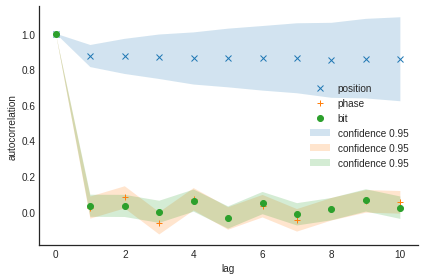

In [5]:
fig,ax = plt.subplots(figsize=(6,4))

N_LAGS = 10

# sampled position

corrs,confs = acf(sampled_position,nlags=N_LAGS,fft=True,bartlett_confint=True,alpha=0.05)
conf_l,conf_u = confs.T
lags = np.arange(N_LAGS+1)
ax.fill_between(lags,conf_l,conf_u,alpha=0.2,label='confidence 0.95')
ax.plot(lags,corrs,'x',label='position')

# sampled phase

corrs,confs = acf(sampled_phase,nlags=N_LAGS,fft=True,bartlett_confint=True,alpha=0.05)
conf_l,conf_u = confs.T
ax.fill_between(lags,conf_l,conf_u,alpha=0.2,label='confidence 0.95')
ax.plot(lags,corrs,'+',label='phase')

# sampled bit

corrs,confs = acf(sampled_bit,nlags=N_LAGS,fft=True,bartlett_confint=True,alpha=0.05)
conf_l,conf_u = confs.T
ax.fill_between(lags,conf_l,conf_u,alpha=0.2,label='confidence 0.95')
ax.plot(lags,corrs,'o',label='bit')

ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

ax.legend()
plt.tight_layout()
plt.show()

fig.savefig('brownian_motion_trng_autocorr.svg')

In [6]:
from IPython.display import display

outs = []
outs.append(kpss(sampled_position))
outs.append(kpss(sampled_phase))
outs.append(kpss(sampled_bit))
out1 = pd.DataFrame(outs,columns=['statistic','p-value','variance lags','extreme vals'])
out1 = out1[['statistic','p-value']]
out1['test']='KPSS'
#print(outs[['test statistic','p-value']].to_latex())

N_LAGS = 10

outs = []
outs.append(tuple(acorr_ljungbox(sampled_position,lags=N_LAGS).loc[N_LAGS]))
outs.append(tuple(acorr_ljungbox(sampled_phase,lags=N_LAGS).loc[N_LAGS]))
outs.append(tuple(acorr_ljungbox(sampled_bit,lags=N_LAGS).loc[N_LAGS]))
out2 = pd.DataFrame(outs,columns=['statistic','p-value'])
out2['test'] = 'Ljung-Box'

index_dict = {0:'position',1:'phase',2:'bit'}
out1['data']= out1.index.map(index_dict.get)
out2['data']= out2.index.map(index_dict.get)

out = pd.concat([out1,out2]).pivot(index='data',columns=['test',])
out = out.swaplevel(0,1,axis=1).sort_index(axis=1)
display(out)
print(out.to_latex())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


test          KPSS           Ljung-Box             
           p-value statistic   p-value    statistic
data                                               
bit       0.010000  0.832198  0.123605    15.238512
phase     0.024151  0.583342  0.001818    27.980404
position  0.010000  5.058589  0.000000  7512.124646

\begin{tabular}{lrrrr}
\toprule
test & \multicolumn{2}{l}{KPSS} & \multicolumn{2}{l}{Ljung-Box} \\
{} &   p-value & statistic &   p-value &    statistic \\
data     &           &           &           &              \\
\midrule
bit      &  0.010000 &  0.832198 &  0.123605 &    15.238512 \\
phase    &  0.024151 &  0.583342 &  0.001818 &    27.980404 \\
position &  0.010000 &  5.058589 &  0.000000 &  7512.124646 \\
\bottomrule
\end{tabular}

